# EMIT MF–CV comparison on whole tile

Try running MF on an entire tile containing synthetic plumes and see if we get similar results to CV, to determine if our insertion logic is correct.

In [1]:
import joblib
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

In [18]:
# NOTE this EMIT ID already contains a GT plume!!!
# Could be informative to have both real an synthetic plumes in tile
# if they don't overlap
emit_id = "EMIT_L1B_RAD_001_20240212T214843_2404314_025"
obs_id = emit_id.replace('_RAD_', '_OBS_', 1)

## Step 1: Create synthetic radiance datacube

Environment: conda methane-cv

In [25]:
from src.azure_wrap.ml_client_utils import get_azureml_uri, initialize_ml_client, make_acceptable_uri
from src.data.generation.base import DataGenerationConfig
from src.data.generation.emit_generation import EMITDataGeneration, EMITL2AMaskLabel

In [10]:
ml_client = initialize_ml_client()
catalog_uri = make_acceptable_uri(
    str(get_azureml_uri(ml_client, "carbonmapper_plumes/_emit_plume_uris_training.json"))
)

config = DataGenerationConfig(
    plume_catalog=catalog_uri,
    plume_type="carbonmapper",
    out_dir="/tmp",
    crop_size=1242,  # shorter dim of EMIT
    quality_thresholds={
        "main_crop": (0, 0.5),
    },
    random_seed=5,
    transformation_params={
        "modulate": 1.0,
        "resize": 1.0,
    },
    azure_cluster=False,
    git_revision_hash="",
    test=False,
    ml_client=None,
    s3_client=None,
    storage_options=None,
    psf_sigma=38.22,
    target_spatial_resolution=60,
    concentration_rescale_value=4,
    plume_proba_dict={0: 0.1667, 1: 0.1667, 2: 0.1667, 3: 0.1667, 4: 0.1666, 5: 0.1666},
    hapi_data_path="azureml://subscriptions/6e71ce37-b9fe-4c43-942b-cf0f7e78c8ab/resourcegroups/orbio-ml-rg/workspaces/orbio-ml-ml-workspace/datastores/workspaceblobstore/paths/data/radtran/hapi/v1.1.1.0",
)


Found the config file in: /config.json


In [12]:
generator = EMITDataGeneration(
    emit_id=emit_id,
    emit_mask_labels=[
        EMITL2AMaskLabel.CLOUD,
        EMITL2AMaskLabel.CIRRUS_CLOUD,
        EMITL2AMaskLabel.DILATED_CLOUD,
        EMITL2AMaskLabel.WATER,
        EMITL2AMaskLabel.SPACECRAFT,
    ],
    **config.model_dump(),
)

Found the config file in: /config.json


In [ ]:
%%time
data = generator.download_data()
tile_level_data = generator.prepare_tile_level_data(data)
crops = generator.generate_crops(data)
data_items = generator.generate_synthetic_data_items(generator.plume_files, crops, **tile_level_data)


In [16]:
x = [*data_items]

/anaconda/envs/methane-cv/lib/python3.10/site-packages/scipy/special/_logsumexp.py:219: RuntimeWarning: overflow encountered in divide                  | 0/7 [00:00<?, ?it/s]
  s = xp.where(s == 0, s, s/m)
Computing normalized brightness: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 285/285 [00:07<00:00, 38.81it/s]
2025-05-05 21:00:32,497 - INFO - Biggest reduction factor: 0.7765


In [19]:
type(x[0])

src.data.common.data_item.MonoTemporalPlumesDataItem

In [21]:
x[0].crop_main.shape

(285, 1242, 1242)

In [22]:
x[0].mask_main.shape

(1242, 1242)

In [29]:
x[0].size

1242

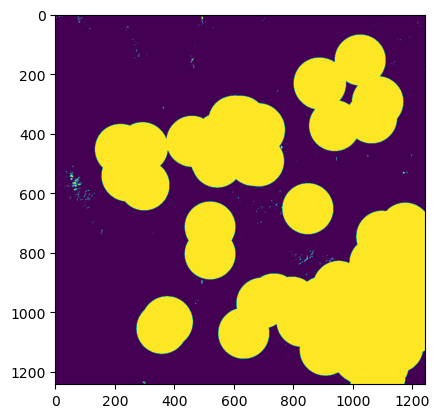

In [24]:
plt.imshow(x[0].mask_main)

In [31]:
joblib.dump(x[0], f"{emit_id}_synthetic_plumes.joblib", compress=3)

['EMIT_L1B_RAD_001_20241202T180154_2433712_009_synthetic_plumes.joblib']

In [2]:
! du -sh EMIT_L1B_RAD_001_20241202T180154_2433712_009_synthetic_plumes.joblib

1.5G	EMIT_L1B_RAD_001_20241202T180154_2433712_009_synthetic_plumes.joblib


## Step 2: Download real data


In [87]:
import earthaccess
import pystac_client

In [88]:
client = pystac_client.Client.open("https://cmr.earthdata.nasa.gov/stac/LPCLOUD")

In [89]:
query = client.search(
    collections=["EMITL1BRAD_001"],
    ids=[emit_id],
)

In [90]:
items = [*query.items()]

In [91]:
items[0]

<Item id=EMIT_L1B_RAD_001_20240212T214843_2404314_025>

In [92]:
earthaccess.login()

In [93]:
earthaccess.download(
    items[0].assets[f"001/{emit_id}/{obs_id}"].href,
    "./"
)

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

['EMIT_L1B_OBS_001_20240212T214843_2404314_025.nc']

## Step 3: Insert synthetic data into real data

Bearing in mind our synthetic data is the top-left 1242 x 1242 pixels (needs to be square for insertion so we took the lesser dim)

In [20]:
rad_ds = xr.open_dataset("EMIT_L1B_RAD_001_20241202T180154_2433712_009.nc")

In [21]:
rad_ds

<xarray.Dataset> Size: 2GB
Dimensions:            (downtrack: 1280, crosstrack: 1242, bands: 285)
Dimensions without coordinates: downtrack, crosstrack, bands
Data variables:
    radiance           (downtrack, crosstrack, bands) float32 2GB ...
    flat_field_update  (crosstrack, bands) float32 1MB ...
Attributes: (12/38)
    ncei_template_version:             NCEI_NetCDF_Swath_Template_v2.0
    summary:                           The Earth Surface Mineral Dust Source ...
    keywords:                          Imaging Spectroscopy, minerals, EMIT, ...
    Conventions:                       CF-1.63
    sensor:                            EMIT (Earth Surface Mineral Dust Sourc...
    instrument:                        EMIT
    ...                                ...
    southernmost_latitude:             32.466390628752585
    spatialResolution:                 0.000542232520256367
    spatial_ref:                       GEOGCS["WGS 84",DATUM["WGS_1984",SPHER...
    geotransform:                      [-1.12271688e+02  5.42232520e-04 -0.00...
    day_night_flag:                    Day
    title:                             EMIT L1B At-Sensor Calibrated Radiance...

In [26]:
synthetic_rad = joblib.load(f"{emit_id}_synthetic_plumes.joblib").crop_main

In [36]:
# we need bands-last
synthetic_rad = np.rollaxis(synthetic_rad, 0, 3)

In [38]:
rad_ds["radiance"].shape, synthetic_rad.shape

((1280, 1242, 285), (1242, 1242, 285))

(-0.5, 1241.5, 1241.5, -0.5)

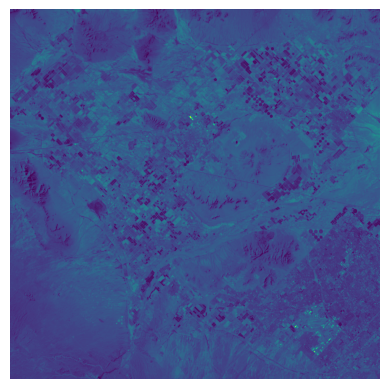

In [41]:
# Before inserting
plt.imshow(rad_ds["radiance"].isel(downtrack=slice(0, 1242), crosstrack=slice(0, 1242), bands=35))
plt.axis("off")

In [46]:
rad_ds["radiance"].shape

(1280, 1242, 285)

In [47]:
rad_ds["radiance"][:1242, :1242] = synthetic_rad

(-0.5, 1241.5, 1241.5, -0.5)

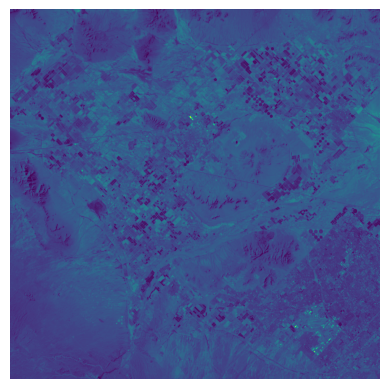

In [49]:
# After inserting
plt.imshow(rad_ds["radiance"].isel(downtrack=slice(0, 1242), crosstrack=slice(0, 1242), bands=35))
plt.axis("off")

In [48]:
np.allclose(
    rad_ds["radiance"].isel(downtrack=slice(0, 1242), crosstrack=slice(0, 1242)).values,
    synthetic_rad,
)

True

In [55]:
rad_ds.to_netcdf(
    "EMIT_L1B_RAD_001_20241202T180154_2433712_009_synthetic_plumes.nc",
    mode="a",
    group="/",
)

In [60]:
! du -sh EMIT_L1B_*_001_20241202T180154_2433712_009*

104M	EMIT_L1B_OBS_001_20241202T180154_2433712_009.nc
1.8G	EMIT_L1B_RAD_001_20241202T180154_2433712_009.nc
4.0K	EMIT_L1B_RAD_001_20241202T180154_2433712_009_original.nc
1.5G	EMIT_L1B_RAD_001_20241202T180154_2433712_009_synthetic_plumes.joblib
1.8G	EMIT_L1B_RAD_001_20241202T180154_2433712_009_synthetic_plumes.nc


## Step 4: Create ENVI

Environment: poetry data_product

add `spectral` dependency to conda

In [5]:
from satellite_data_product.emit.create_envi_files import convert_nc_to_envi

In [3]:
! du -sh {emit_id}_synthetic_plumes.nc

1.8G	EMIT_L1B_RAD_001_20240212T214843_2404314_025_synthetic_plumes.nc


In [6]:
convert_nc_to_envi(
    f"{emit_id}_synthetic_plumes.nc",
    ".",
    "radiance",
)

ConvertNcToEnviResult(envi_img_path='./EMIT_L1B_RAD_001_20240212T214843_2404314_025_synthetic_plumes_radiance.img', glt_transfor_model=GltTransformModel(rad_glt_file_path=PosixPath('EMIT_L1B_RAD_001_20240212T214843_2404314_025_synthetic_plumes_glt.img'), geotransform=array([-1.02754965e+02,  5.42232520e-04, -0.00000000e+00,  3.20103731e+01,
       -0.00000000e+00, -5.42232520e-04])))

In [7]:
convert_nc_to_envi(
    f"{obs_id}.nc",
    ".",
    "obs",
)

ConvertNcToEnviResult(envi_img_path='./EMIT_L1B_OBS_001_20240212T214843_2404314_025_obs.img', glt_transfor_model=GltTransformModel(rad_glt_file_path=PosixPath('EMIT_L1B_OBS_001_20240212T214843_2404314_025_glt.img'), geotransform=array([-1.02754965e+02,  5.42232520e-04, -0.00000000e+00,  3.20103731e+01,
       -0.00000000e+00, -5.42232520e-04])))

## Step 5: Run MF

In [8]:
import os
from pathlib import Path

from pydantic import BaseModel

from lib.utils.blob_client import create_blob_client
from lib.utils.processing_utils import convert_ppm_m_to_mol_m2
from satellite_data_product.emit.ch4_target_absorption_generation import main as create_ch4_target
from satellite_data_product.emit.matched_filter import MatchedFilterParams, matched_filter
from satellite_data_product.emit.models.models import GltTransformModel, RunConfigParams, path_config
from satellite_data_product.emit.models.settings import Settings, settings

In [9]:
os.environ["GOOGLE_CLOUD_PROJECT"] = "orbio-development"

In [19]:
class EnviData(BaseModel):
    rad_hdr: Path
    rad_img: Path
    obs_hdr: Path
    obs_img: Path


class EnviCreationResult(BaseModel):
    # date: datetime
    envi_paths: EnviData
    # tile_attributes: GranuleAttributes


envi_creation_result = EnviCreationResult(
    envi_paths=EnviData(
        rad_hdr=Path(f"{emit_id}_synthetic_plumes_radiance.hdr"),
        rad_img=Path(f"{emit_id}_synthetic_plumes_radiance.img"),
        obs_hdr=Path(f"{obs_id}_obs.hdr"),
        obs_img=Path(f"{obs_id}_obs.img"),
    )
)

In [20]:
# reimplement target creation so we can sidestep the granuleattributes object

from satellite_data_product.emit.ch4_target_absorption_generation import _calc_sza
from satellite_data_product.emit.utils.target_generation import main as target_generation


def target_creation(envi_creation_result, output_dir, atmos_data_path):
    save_path = Path(output_dir, "chr_target")

    # TODO replace these calcs with reading from the tile_attributes.json downloaded ?
    sza = _calc_sza(obs_file_hdr=envi_creation_result.envi_paths.obs_hdr)

    # elevation = _calc_mean_elevation(obs_file_hdr=envi_creation_result.envi_paths.obs_hdr)
    mean_elevation = 0  # TODO: Use a constant for now until can calclulate our own from a loc file
    mean_h2o = 1.3  # TODO: Use constant for now, in the future h20 values could be calculated from the lv1b data
    mean_elevation = 0  # TODO: Use a constant for now until can calclulate our own from a loc file

    save_path = Path(output_dir, "chr_target")

    target_generation(
        [
            "-z",
            str(sza),
            "-s",
            "100",
            "-g",
            str(mean_elevation),
            "-w",
            str(mean_h2o),
            "--output",
            str(save_path),
            "--hdr",
            str(envi_creation_result.envi_paths.rad_hdr),
            "--atmos_data_path",
            str(atmos_data_path),
        ]
    )
    return save_path

In [21]:
blob_client = create_blob_client(settings.CLOUD_PLATFORM)

print("Creating ch4 target absorption...")
# NOTE: the `atmos_data_path` points to a location in cloud storage where MODTRAN data is stored and used
# to generate the CH4 targets. These data must be present in `SATELLITE_DATA_PRODUCT_BUCKET` or target
# creation will fail.
atmos_data_path = Path(
    f"{blob_client.protocol}/{settings.SATELLITE_DATA_PRODUCT_BUCKET}/{path_config.ATMOS_DATA_PATH_PREFIX}"
)
# ch4_target_creation_result = create_ch4_target(envi_creation_result, path_config.CH4_OUTPUTS_DIR, atmos_data_path)
ch4_target_path = target_creation(envi_creation_result, ".", atmos_data_path)

print("Calculating matched filter...")
spillover_prefix = f"{blob_client.protocol}/{settings.SATELLITE_DATA_PRODUCT_BUCKET}/emit_data/spillover"

filter_params = MatchedFilterParams(
    radiance_img_file_path=envi_creation_result.envi_paths.rad_img,
    ch4_target_path=ch4_target_path,
    output_file="retreival_ppmm",
)
retrieval_path = matched_filter(filter_params, spillover_prefix)

print("Retrieval created")

print("Ch4 retrieval transformations complete")
print("WARNING retrieval still in ppmm")

/home/ubuntu/.cache/pypoetry/virtualenvs/data-product-mcTPXm_z-py3.10/lib/python3.10/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


Creating ch4 target absorption...
INFO:satellite_data_product.emit.utils.target_generation:{"event": "loading ch4 modtran data", "level": "info", "lineno": 222, "func_name": "load_ch4_dataset", "filename": "target_generation.py", "timestamp": "2025-05-06T13:00:12.132562Z"}


/home/ubuntu/.cache/pypoetry/virtualenvs/data-product-mcTPXm_z-py3.10/lib/python3.10/site-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


INFO:satellite_data_product.emit.utils.target_generation:{"event": "loaded data", "level": "info", "lineno": 234, "func_name": "load_ch4_dataset", "filename": "target_generation.py", "timestamp": "2025-05-06T13:00:22.004843Z"}
Calculating matched filter...
INFO:satellite_data_product.emit.utils.target_generation:{"event": "Started processing input file: \"EMIT_L1B_RAD_001_20240212T214843_2404314_025_synthetic_plumes_radiance.img\"", "level": "info", "lineno": 158, "func_name": "matched_filter", "filename": "matched_filter.py", "timestamp": "2025-05-06T13:00:22.370177Z"}
INFO:satellite_data_product.emit.utils.target_generation:{"event": "Active wavelength range: [500.0, 2450.0]: 37784 channels", "level": "info", "lineno": 174, "func_name": "matched_filter", "filename": "matched_filter.py", "timestamp": "2025-05-06T13:00:22.373925Z"}
INFO:satellite_data_product.emit.utils.target_generation:{"event": "load target library", "level": "info", "lineno": 177, "func_name": "matched_filter", "fi

2025-05-06 13:00:23,808	INFO worker.py:1852 -- Started a local Ray instance.


INFO:satellite_data_product.emit.utils.target_generation:{"event": "Processing chunk 1 of 1.", "level": "info", "lineno": 217, "func_name": "matched_filter", "filename": "matched_filter.py", "timestamp": "2025-05-06T13:00:25.344024Z"}
INFO:satellite_data_product.emit.utils.target_generation:{"event": "Radiance shape for chunk: (1280, 285, 1242)", "level": "info", "lineno": 221, "func_name": "matched_filter", "filename": "matched_filter.py", "timestamp": "2025-05-06T13:00:26.229203Z"}
INFO:satellite_data_product.emit.utils.target_generation:{"event": "chunk shape: (1280, 1, 1242)", "level": "info", "lineno": 222, "func_name": "matched_filter", "filename": "matched_filter.py", "timestamp": "2025-05-06T13:00:26.230484Z"}
INFO:satellite_data_product.emit.utils.target_generation:{"event": "create masks", "level": "info", "lineno": 224, "func_name": "matched_filter", "filename": "matched_filter.py", "timestamp": "2025-05-06T13:00:26.231574Z"}
INFO:satellite_data_product.emit.utils.target_gen

In [22]:
import rasterio

In [23]:
with rasterio.open("retreival_ppmm") as reader:
    profile = reader.profile
    print(profile)
    ppmm = reader.read()

{'driver': 'ENVI', 'dtype': 'float32', 'nodata': -9999.0, 'width': 1242, 'height': 1280, 'count': 1, 'crs': None, 'transform': Affine(1.0, 0.0, 0.0,
       0.0, 1.0, 0.0), 'blockxsize': 1242, 'blockysize': 1, 'tiled': False, 'interleave': 'line'}


/home/ubuntu/.cache/pypoetry/virtualenvs/data-product-mcTPXm_z-py3.10/lib/python3.10/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [24]:
ppmm[ppmm == -9999] = np.nan
molm2 = convert_ppm_m_to_mol_m2(ppmm)

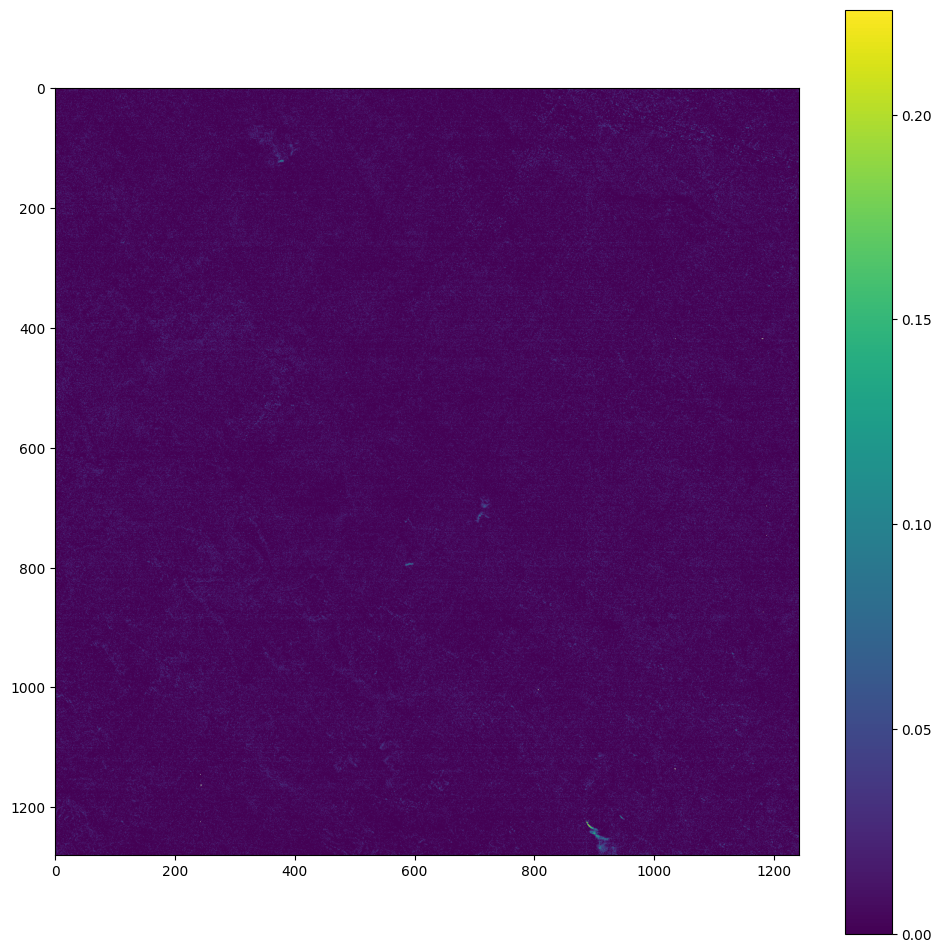

In [25]:
fig = plt.figure(figsize=(12, 12))
plt.imshow(molm2[0], vmin=0)
plt.colorbar()

In [26]:
profile.update({"driver": "GTiff", "compress": "zlib", "interleave": "pixel"})

In [27]:
with rasterio.open(f"{emit_id}_mf_retrieval_molm2.tif", mode="w", **profile) as writer:
    writer.write(molm2)

/home/ubuntu/.cache/pypoetry/virtualenvs/data-product-mcTPXm_z-py3.10/lib/python3.10/site-packages/rasterio/__init__.py:366: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(
